<a href="https://colab.research.google.com/github/ivanmcardoso/tcc2-pcb-defect-detection/blob/main/colab/PCB_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baixa arquivos do dataset

### Fazer upload do arquivo kaggle.json para poder acessar ao dataset

In [ ]:
from google.colab import files
files.upload()

### Faz download do dataset e extrai os arquivos do .zip

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d akhatova/pcb-defects
!unzip -qq pcb-defects.zip
!dir

100% 1.87G/1.88G [00:16<00:00, 129MB/s]
100% 1.88G/1.88G [00:16<00:00, 123MB/s]
kaggle.json  PCB_DATASET  pcb-defects.zip  sample_data


# Configura Dataset e treina rede

Instala dependências necessárias

In [ ]:
!pip install pylabel
!pip install ultralytics

Configura o dataset para o formato do YOLO

In [ ]:
from pylabel import importer
import os
import shutil

# Path central do projeto = "./"
base_dir = os.getcwd()

# Cria pastas central para as notações e imagens caso não existam 
if not os.path.exists('Annotations'):
    os.mkdir("Annotations")
if not os.path.exists('images'):
    os.mkdir("images")


def group_files_in_target_directory(m_origin, target):
    files = os.listdir(m_origin)

    # Copia todos os arquivos do diretorio original para pasta central
    for file_name in files:
        shutil.copy(m_origin + '/' + file_name, target + '/' + file_name)
    print(f"Arquivos copiados de {m_origin} para {target}")



# Path original dos diretórios do dataset 
origin_annotation_dir = f'{base_dir}/PCB_DATASET/Annotations'
origin_images_dir = f'{base_dir}/PCB_DATASET/images'
# Path central dos diretórios do dataset
target_annotation_dir = f'{base_dir}/Annotations/'
target_image_dir = f'{base_dir}/images/'

# Copia todas as notações para diretório central
annotation_dirs = os.listdir(origin_annotation_dir)
for a_origin in annotation_dirs:
    group_files_in_target_directory(origin_annotation_dir + '/' + a_origin, target_annotation_dir)

# Copia todas as imagens para diretório central
image_dirs = os.listdir(origin_images_dir)
for i_origin in image_dirs:
    group_files_in_target_directory(origin_images_dir + '/' + i_origin, target_image_dir)

# Formata arquivos para estrutura do YOLO
path_to_annotations = target_annotation_dir
path_to_images = target_image_dir
dataset = importer.ImportVOC(path=path_to_annotations, path_to_images=path_to_images)
dataset.splitter.dataset.splitter.StratifiedGroupShuffleSplit(train_pct=.6, val_pct=.2, test_pct=.2, batch_size=1)
dataset.analyze.ShowClassSplits()
dataset.export.ExportToYoloV5(copy_images=True, use_splits=True)

# Remove diretórios centralizadores
shutil.rmtree(path_to_annotations)
shutil.rmtree(path_to_images)

## Treinamento da rede com 50 eṕocas

In [ ]:
from ultralytics import YOLO

# Carrega modelo preteinado YOLOv8n (versão mais leve da rede)
model = YOLO('yolov8n.pt')

# Treina a rede com o dataset em 50 épocas
data_path = './training/dataset.yaml'
results = model.train(data=data_path, epochs=50)

# Avaliação de desempenho da rede
results = model.val()

100%|██████████| 6.23M/6.23M [00:00<00:00, 99.0MB/s]
Ultralytics YOLOv8.0.78 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./training/dataset.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=F

## Salva versão da rede

In [ ]:
model.export()

Ultralytics YOLOv8.0.78 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU

PyTorch: starting from runs/detect/train/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (6.0 MB)

TorchScript: starting export with torch 2.0.0+cu118...
TorchScript: export success ✅ 1.9s, saved as runs/detect/train/weights/best.torchscript (11.9 MB)

Export complete (2.7s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=640 
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=640 data=./training/dataset.yaml 
Visualize:       https://netron.app


'runs/detect/train/weights/best.torchscript'

# Testa rede

### Upload do modelo salvo (Opcional)

In [ ]:
from google.colab import files
files.upload()

### Carrega rede treinada

In [16]:
from ultralytics import YOLO
import os
import random
import cv2
from ultralytics.yolo.utils.plotting import Annotator
from google.colab.patches import cv2_imshow

base_dir = os.getcwd()
# PAth da rede recem upada
model_path = f"{base_dir}/best.pt"
# Path da rede recem treinada
# model_path = f"{base_dir}/runs/detect/train/weights/best.pt"

#Carrega modelo
model = YOLO(model_path)
print("Modelo carregado com sucesso")

In [ ]:
model.val()

### Teste com uma imagem do dataset

/content/training/images/train/11_mouse_bite_03.jpg
(640, 640, 3)


0: 640x640 5 mouse_bites, 205.9ms
Speed: 1.4ms preprocess, 205.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


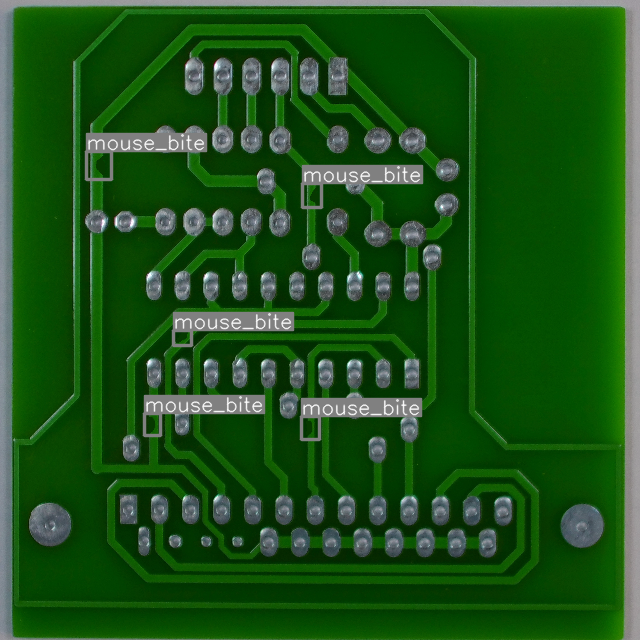

In [20]:
img_base_dir = f"{base_dir}/training/images/train"
imgs = os.listdir(img_base_dir)
file_name = imgs[random.randint(1, len(imgs)-1)]
src_path = f"{img_base_dir}/{file_name}"
print(src_path)
img = cv2.imread(src_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640,640))
print(img.shape)

results = model.predict(img)
for r in results:

    annotator = Annotator(img)

    boxes = r.boxes
    for box in boxes:
        b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
        c = box.cls
        annotator.box_label(b, model.names[int(c)])

img = annotator.result()
cv2_imshow(img)